## 1. Market Data Simulation (Geometric Brownian Motion)

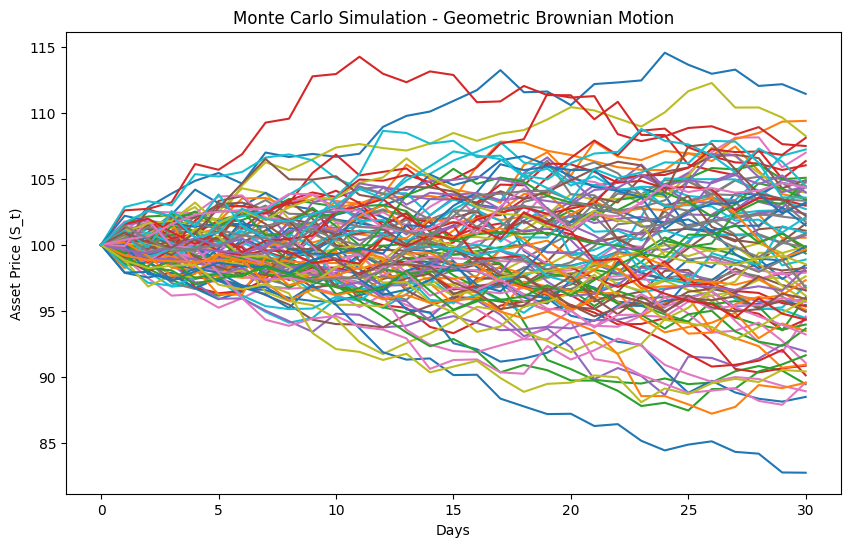

Data shape: (5000, 31)


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Market Parameters
S0 = 100       # Initial Price
K = 100        # Option Strike Price
T = 30/365     # Maturity (30 days)
r = 0.0        # Risk-free rate (simplified to 0 for Deep Hedging context)
sigma = 0.2    # Volatility (20%)
N_steps = 30   # One time step per day (Daily rebalancing)
N_sims = 5000  # Number of simulations for training

# 2. Path Generation (Monte Carlo / GBM)
def generate_paths(S0, T, r, sigma, n_steps, n_sims):
    dt = T / n_steps
    # Simulate random shocks (Brownian Motion dW)
    # Use a (n_sims, n_steps) matrix for vectorization (speed)
    dW = np.random.normal(0, np.sqrt(dt), (n_sims, n_steps))

    # Initialize price matrix
    S = np.zeros((n_sims, n_steps + 1))
    S[:, 0] = S0

    # Loop to construct paths (Vectorized across simulations)
    for t in range(1, n_steps + 1):
        # Discrete GBM formula: S(t+1) = S(t) * exp((r - 0.5*sigma^2)*dt + sigma*dW)
        S[:, t] = S[:, t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * dW[:, t-1])

    return S

# Execution
paths = generate_paths(S0, T, r, sigma, N_steps, N_sims)

# 3. Visualization (Sanity check)
plt.figure(figsize=(10, 6))
plt.plot(paths[:100, :].T) # Plot only the first 100 paths for clarity
plt.title("Monte Carlo Simulation - Geometric Brownian Motion")
plt.xlabel("Days")
plt.ylabel("Asset Price (S_t)")
plt.show()

print(f"Data shape: {paths.shape}")
# Should print (5000, 31) -> 5000 scenarios of 31 days (Day 0 to Day 30)

## 2. Black-Scholes Delta Hedging (Benchmark)


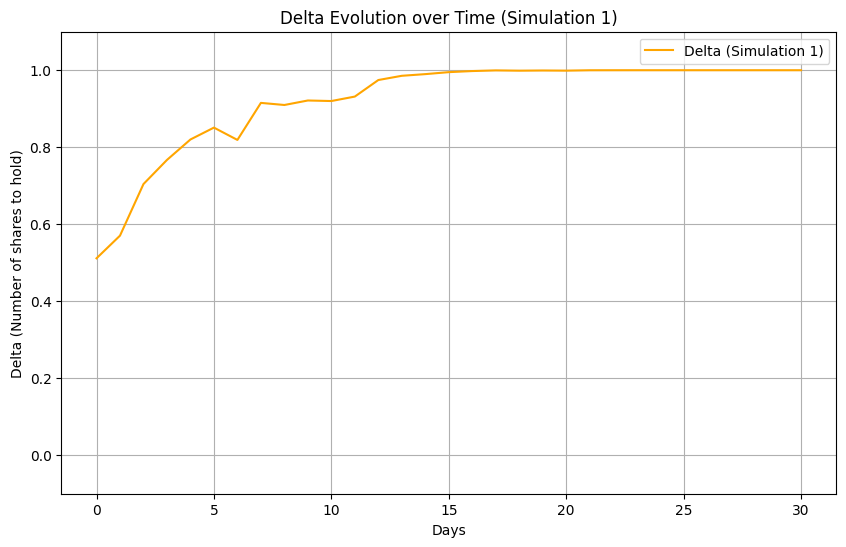

Delta Matrix Shape: (5000, 31)


In [2]:
from scipy.stats import norm

# 1. Black-Scholes Delta Function
def black_scholes_delta(S, K, T, r, sigma, time_grid):
    """
    Computes Delta for the entire price matrix S at once.
    time_grid: vector of time steps t (from 0 to T)
    """
    # Calculate time to maturity
    time_to_maturity = T - time_grid

    # Avoid division by zero at the very last step (where T-t = 0)
    # We replace 0s with a tiny epsilon value just for calculation stability
    safe_ttm = np.maximum(time_to_maturity, 1e-10)

    # Compute d1 (Numpy Broadcasting: S is (5000, 31), safe_ttm is (31,))
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * safe_ttm) / (sigma * np.sqrt(safe_ttm))

    delta = norm.cdf(d1)
    return delta

# 2. Time Grid Creation
time_grid = np.linspace(0, T, N_steps + 1) # From t=0 to t=T

# 3. Compute all Deltas
deltas = black_scholes_delta(paths, K, T, r, sigma, time_grid)

# 4. Visual Verification
plt.figure(figsize=(10, 6))
# Plot Delta for the first simulated path
plt.plot(deltas[0, :], label="Delta (Simulation 1)", color='orange')
plt.title("Delta Evolution over Time (Simulation 1)")
plt.xlabel("Days")
plt.ylabel("Delta (Number of shares to hold)")
plt.ylim(-0.1, 1.1) # Call Delta is always between 0 and 1
plt.legend()
plt.grid(True)
plt.show()

print(f"Delta Matrix Shape: {deltas.shape}")

Theoretical Option Price (Premium): 2.2872


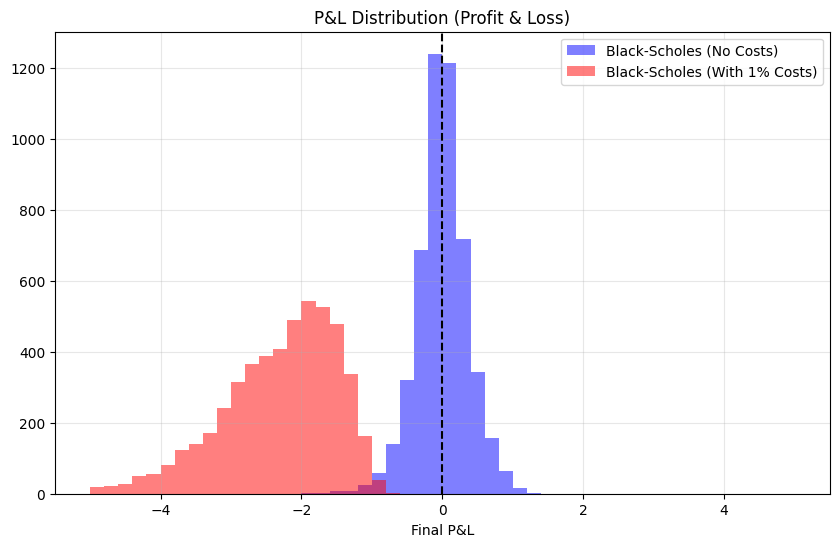

Mean P&L (No Costs): 0.0002 (Should be ~0)
Mean P&L (With Costs): -2.3146 (This is what we want to improve!)


In [3]:
# ==========================================
# STEP 3: P&L Simulation with Transaction Costs
# ==========================================

# 1. Theoretical Option Price at t=0 (Premium received upfront)
# Black-Scholes Formula for Call
d1_0 = (np.log(S0/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
d2_0 = d1_0 - sigma*np.sqrt(T)
price_call_0 = S0 * norm.cdf(d1_0) - K * np.exp(-r*T) * norm.cdf(d2_0)

print(f"Theoretical Option Price (Premium): {price_call_0:.4f}")

# 2. Cost Parameters
transaction_cost = 0.01  # 1% transaction fee (High, but chosen for educational purpose to highlight the effect)

# 3. Cashflow Calculation for Black-Scholes Strategy

# A. Asset Price Variation (S_t+1 - S_t)
# We observe movement between t and t+1
dS = paths[:, 1:] - paths[:, :-1]

# B. Hedging Portfolio Gain (Trading P&L)
# We hold delta[t] while price moves from S[t] to S[t+1]
# Note: we take deltas[:, :-1] because the last delta (at T) is not used for hedging future steps
strategy_daily_pnl = deltas[:, :-1] * dS

# C. Transaction Cost Calculation
# Position change: |delta_t - delta_{t-1}|
# Note: at time 0, we go from 0 shares to delta_0 shares (initial hedge)
positions = deltas
trade_amounts = np.diff(positions, axis=1, prepend=0) # prepend=0 to handle the initial trade

# Cost = Rate * Current_Price * |Traded_Volume|
costs = transaction_cost * paths * np.abs(trade_amounts)

# 4. Final Total P&L
# PnL = Premium received + Total Trading Gains - Total Costs - Final Payoff
total_trading_pnl = np.sum(strategy_daily_pnl, axis=1)
total_costs = np.sum(costs, axis=1)
final_payoff = np.maximum(paths[:, -1] - K, 0) # (S_T - K)+

pnl_with_costs = price_call_0 + total_trading_pnl - total_costs - final_payoff
pnl_without_costs = price_call_0 + total_trading_pnl - final_payoff

# 5. Visualization: The "Cost" Problem
plt.figure(figsize=(10, 6))

# Histogram without costs (Should be a peak around 0)
plt.hist(pnl_without_costs, bins=50, alpha=0.5, label='Black-Scholes (No Costs)', color='blue', range=(-5, 5))

# Histogram WITH costs (Should be shifted left = LOSS)
plt.hist(pnl_with_costs, bins=50, alpha=0.5, label='Black-Scholes (With 1% Costs)', color='red', range=(-5, 5))

plt.title("P&L Distribution (Profit & Loss)")
plt.xlabel("Final P&L")
plt.legend()
plt.grid(True, alpha=0.3)
plt.axvline(x=0, color='black', linestyle='--') # The "Break-even" line
plt.show()

print(f"Mean P&L (No Costs): {np.mean(pnl_without_costs):.4f} (Should be ~0)")
print(f"Mean P&L (With Costs): {np.mean(pnl_with_costs):.4f} (This is what we want to improve!)")

## 3. Training the Deep Hedging Agent (Reinforcement Learning)

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input

# ==========================================
# DATA PREPARATION (FEATURES)
# ==========================================
# The AI needs normalized data to learn effectively.
# Feature 1: Log-Moneyness = log(S_t / K) (Where is price relative to strike?)
# Feature 2: Time to Maturity = T - t (How much time is left?)

# Create tensor of shape (N_sims, N_steps, 2)
# X[:, t, 0] -> Log Moneyness
# X[:, t, 1] -> Time to Maturity
X_train = np.zeros((N_sims, N_steps, 2))

for t in range(N_steps):
    X_train[:, t, 0] = np.log(paths[:, t] / K)      # Feature 1
    X_train[:, t, 1] = T - (t * (T/N_steps))        # Feature 2

# Raw price tensor (needed for P&L calculation in the computational graph)
S_tensor = tf.constant(paths, dtype=tf.float32)

# ==========================================
# MODEL ARCHITECTURE (NEURAL NETWORK)
# ==========================================

# 1. Define the "Brain" (Sub-network deciding at each step t)
# It is a simple MLP (Multi-Layer Perceptron)
inputs_step = Input(shape=(2,)) # Takes (Moneyness, Time)
x = layers.Dense(32, activation='relu')(inputs_step)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
output_delta = layers.Dense(1, activation='sigmoid')(x) # Sigmoid because Delta is between 0 and 1 for a Call

# Create this sub-model to reuse at each time step (Shared Weights)
decision_model = models.Model(inputs=inputs_step, outputs=output_delta, name="Strategy_Network")

# 2. Time Unrolling (Recurrent structure)
# Apply the "Brain" to each day of the simulation
inputs_global = Input(shape=(N_steps, 2))
deltas_list = []

for t in range(N_steps):
    # Extract data for day t
    step_data = inputs_global[:, t, :]
    # Model predicts delta
    delta_t = decision_model(step_data)
    deltas_list.append(delta_t)

# Concatenate to get decision matrix (N_sims, N_steps)
deltas_tensor = layers.concatenate(deltas_list, axis=1)

# ==========================================
# CUSTOM LOSS FUNCTION (Utility Maximization)
# ==========================================

class DeepHedgingModel(models.Model):
    def __init__(self, inputs, outputs, price_paths, strike, cost_factor):
        super().__init__(inputs, outputs)
        self.price_paths = price_paths # (N_sims, N_steps + 1)
        self.strike = strike
        self.cost_factor = cost_factor

    def train_step(self, data):
        # data contains X_train (inputs)
        # No 'y_true' here (Unsupervised/RL context), ignoring tuple if present
        x_batch = data[0] if isinstance(data, tuple) else data

        # Retrieve batch indices (Simplified: using full dataset here)
        # Note: assuming batch_size=N_sims for this prototype

        with tf.GradientTape() as tape:
            # 1. AI predicts deltas
            deltas = self(x_batch, training=True) # Shape (Batch, N_steps)

            # 2. Compute P&L within TensorFlow graph

            S = self.price_paths

            # Trading Gain: delta * (S_next - S_curr)
            dS = S[:, 1:] - S[:, :-1]
            trading_pnl = tf.reduce_sum(deltas * dS, axis=1)

            # Transaction Costs: cost * S * |delta_new - delta_old|
            # Add 0 at start (initial trade)
            zeros = tf.zeros((tf.shape(deltas)[0], 1))
            prev_deltas = tf.concat([zeros, deltas[:, :-1]], axis=1)
            trade_amounts = deltas - prev_deltas

            # Simplify cost by taking price S_t (approx)
            costs = tf.reduce_sum(self.cost_factor * S[:, :-1] * tf.abs(trade_amounts), axis=1)

            # Final Payoff (Liability)
            final_payoff = tf.maximum(S[:, -1] - self.strike, 0.0)

            # Total P&L = Trading - Costs - Payoff
            # (Ignoring initial premium as it is constant)
            total_pnl = trading_pnl - costs - final_payoff

            # 3. Loss Function (Utility)
            # We want to Maximize E[PnL] and Minimize Risk
            # Loss = - Mean(P&L) + lambda * Std(P&L)
            # High lambda = High Risk Aversion
            risk_aversion = 1.0
            loss = -tf.reduce_mean(total_pnl) + risk_aversion * tf.math.reduce_std(total_pnl)

        # 4. Backpropagation
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        return {"loss": loss, "mean_pnl": tf.reduce_mean(total_pnl)}

# ==========================================
# TRAINING
# ==========================================

# Instantiate custom model
model_dh = DeepHedgingModel(inputs=inputs_global,
                            outputs=deltas_tensor,
                            price_paths=S_tensor,
                            strike=K,
                            cost_factor=transaction_cost)

model_dh.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))

print("Starting Deep Hedging AI training...")
# Train for 100 epochs
history = model_dh.fit(X_train, X_train, batch_size=N_sims, epochs=100, verbose=1)

print("Training completed!")

Starting Deep Hedging AI training...
Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 4.5063 - mean_pnl: -2.7754
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 4.4989 - mean_pnl: -2.7637
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 4.4911 - mean_pnl: -2.7503
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 4.4897 - mean_pnl: -2.7413
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 4.4896 - mean_pnl: -2.7321
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 4.4900 - mean_pnl: -2.7248
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 4.4903 - mean_pnl: -2.7216
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 4.4899 - mean_pnl: -2.7220
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 4.4893 - mean_pnl: -2.7250
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 4.4884 - mean_pnl: -2.7289
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 4.4883 - mean_pnl: -2.7333
Epoch 12/100
1/1 ━

## 4. Performance Comparison (AI vs Black-Scholes)

Generating AI predictions...
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


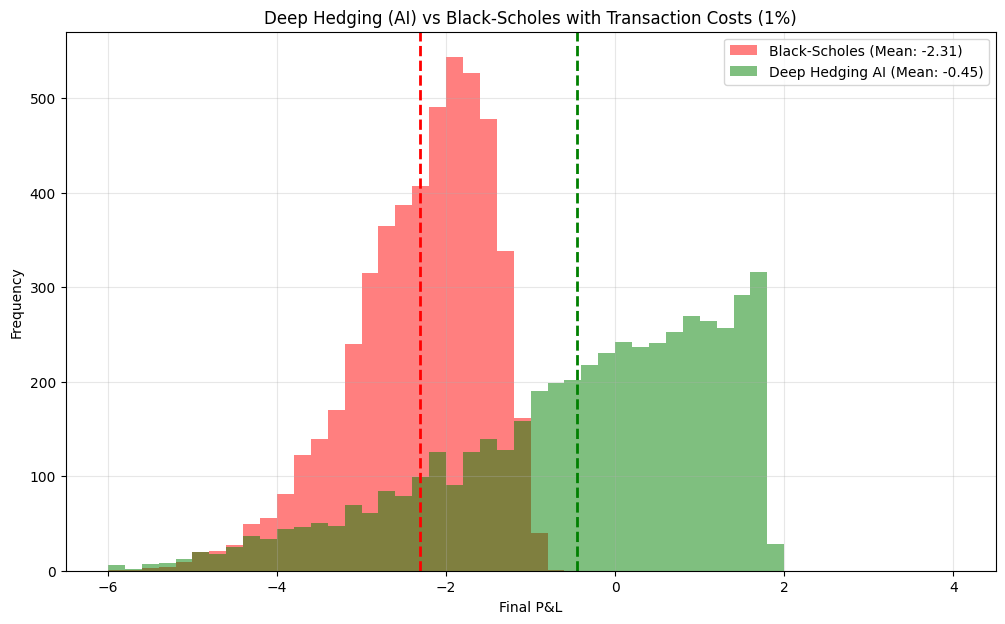

Mean P&L Black-Scholes : -2.3146
Mean P&L Deep Hedging  : -0.4469
------------------------------------------------
✅ SUCCESS: The green curve is to the right of the red one!
AI saved an average of 1.8677 per option by better managing costs.


In [5]:
# ==========================================
# FINAL STEP: COMPARISON AI vs BLACK-SCHOLES
# ==========================================

print("Generating AI predictions...")
# 1. AI predicts Deltas on the entire dataset
ai_deltas = model_dh.predict(X_train)
# Ensure shape is (N_sims, N_steps)
ai_deltas = ai_deltas.reshape(N_sims, N_steps) # (5000, 30)

# 2. AI P&L Calculation

# A. Trading P&L
# dS is (5000, 30) and ai_deltas is same. Direct multiplication.
dS = paths[:, 1:] - paths[:, :-1]
ai_trading_pnl = np.sum(ai_deltas * dS, axis=1)

# B. AI Transaction Costs
# Add a column of zeros at the start (0 shares held initially)
zeros_col = np.zeros((N_sims, 1))
ai_positions = np.hstack([zeros_col, ai_deltas]) # Keep all ai_deltas
ai_trade_amounts = np.diff(ai_positions, axis=1) # Daily trade amounts

# Cost = Rate * Price * |Volume|
# Use paths[:, :-1] (prices S0...S29) to value trades at t0...t29
ai_costs = np.sum(transaction_cost * paths[:, :-1] * np.abs(ai_trade_amounts), axis=1)

# C. AI Total P&L
ai_final_pnl = price_call_0 + ai_trading_pnl - ai_costs - final_payoff

# ==========================================
# FINAL VISUALIZATION
# ==========================================

plt.figure(figsize=(12, 7))

# 1. Black-Scholes Histogram (Red)
plt.hist(pnl_with_costs, bins=50, alpha=0.5, label=f'Black-Scholes (Mean: {np.mean(pnl_with_costs):.2f})', color='red', range=(-6, 4))

# 2. Deep Hedging AI Histogram (Green)
plt.hist(ai_final_pnl, bins=50, alpha=0.5, label=f'Deep Hedging AI (Mean: {np.mean(ai_final_pnl):.2f})', color='green', range=(-6, 4))

plt.title("Deep Hedging (AI) vs Black-Scholes with Transaction Costs (1%)")
plt.xlabel("Final P&L")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True, alpha=0.3)
# Vertical lines for means
plt.axvline(x=np.mean(pnl_with_costs), color='red', linestyle='--', linewidth=2)
plt.axvline(x=np.mean(ai_final_pnl), color='green', linestyle='--', linewidth=2)

plt.show()

# Numerical Summary
bs_loss = np.mean(pnl_with_costs)
ai_loss = np.mean(ai_final_pnl)

print(f"Mean P&L Black-Scholes : {bs_loss:.4f}")
print(f"Mean P&L Deep Hedging  : {ai_loss:.4f}")
print("------------------------------------------------")
if ai_loss > bs_loss:
    diff = ai_loss - bs_loss
    print(f"✅ SUCCESS: The green curve is to the right of the red one!")
    print(f"AI saved an average of {diff:.4f} per option by better managing costs.")
else:
    print("❌ FAILURE: AI has not beaten BS yet.")